In [3]:
import wandb
import numpy as np
import torch

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy.signal import find_peaks




from datagenfordiff.datasetdif import SynthSignalsDataset
# from diff_ts_class import EpsilonThetaClass
# from diff_ts_class import GaussianDiffusionClass

import os

In [14]:
run = wandb.init(project="test_train_2")
artifact = run.use_artifact('fyp_a/test_train_2/bs64_lr0.001_be0.1_ds100_ltl2_bschlinear:v3')
artifact_dir = artifact.download()
model = GaussianDiffusion(EpsilonTheta([256]), input_size=256)
model.load_state_dict(torch.load(f"{artifact_dir}/bs64_lr0.001_be0.1_ds100_ltl2_bschlinear.pth"))

model.eval()

num_signals = 100
batch_size = 10  # You can adjust this batch size based on your system's capability
generated_signals = []

with torch.no_grad():
    while len(generated_signals) < num_signals:
        noise_shape = (batch_size, 1, 256)  # Define the noise shape for the batch
        random_noise = torch.randn(noise_shape, device=model.betas.device)
        batch_signals = model.p_sample_loop(random_noise)
        # Append the generated signals to the list and reshape them immediately
        generated_signals.extend(batch_signals.squeeze().cpu().detach().numpy())

# Convert list to NumPy array
generated_signals = np.array(generated_signals)
if generated_signals.shape[0] > num_signals:
    generated_signals = generated_signals[:num_signals]  # Trim extra signals if any



KeyboardInterrupt: 

In [4]:
def custom_collate_fn(batch):
    signals = torch.stack([item['signals'] for item in batch]).unsqueeze(1)  # Adds a channel dimension
    gt = torch.stack([item['gt'] for item in batch])
    sc = torch.stack([item['sc'] for item in batch])
    return {'signals': signals, 'gt': gt, 'sc': sc}

def plot_mean_signal(train_set_path, class_label, num_signals, generated_signals):
   
    train_loader = DataLoader(torch.load(train_set_path), batch_size=128, shuffle=True, collate_fn=custom_collate_fn)


    signals_accum = []
    for batch_no, data_entry in enumerate(train_loader, start=1):
        signals = data_entry['signals'].squeeze(1)  
        class_labels = data_entry['sc']
        for j in range(signals.size(0)):
            if class_labels[j] == class_label:
                signals_accum.append(signals[j])
                if len(signals_accum) >= num_signals:
                    break
        if len(signals_accum) >= num_signals:
            break
        
    mean_dataset_signal = torch.stack(signals_accum).mean(0)

    # Calculate the mean of generated signals
    mean_generated_signal = np.mean(generated_signals, axis=0)

    # Plotting both mean signals
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(mean_dataset_signal.numpy(), label=f'Mean Dataset Signal for Class {class_label}')
    plt.title(f'Mean Dataset Signal for Class {class_label}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(mean_generated_signal, label='Mean Generated Signal')
    plt.title('Mean Generated Signal for Class {class_label}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.tight_layout()
    plt.show()
    return mean_dataset_signal, mean_generated_signal

    

In [5]:
def plot_envelope(signal_orig, signal_gen, dmin = 1, dmax = 1,  split = False):
    lmin = (np.diff(np.sign(np.diff(signal_orig))) > 0).nonzero()[0] + 1
    # Local maxima
    lmax = (np.diff(np.sign(np.diff(signal_orig))) < 0).nonzero()[0] + 1

    if split:
        # Calculate mean of the signal
        s_mid = np.mean(signal_orig)
        # Pre-sorting of local minima based on relative position with respect to s_mid
        lmin = lmin[signal_orig[lmin] < s_mid]
        # Pre-sorting of local maxima based on relative position with respect to s_mid
        lmax = lmax[signal_orig[lmax] > s_mid]

        # Global minima of dmin-chunks of local minima
        lmin = [i + np.argmin(signal_orig[lmin[i:i + dmin]]) for i in range(0, len(lmin), dmin)]


    lming = (np.diff(np.sign(np.diff(signal_gen))) > 0).nonzero()[0] + 1
    # Local maxima
    lmaxg = (np.diff(np.sign(np.diff(signal_gen))) < 0).nonzero()[0] + 1

    if split:
        # Calculate mean of the signal
        s_midg = np.mean(signal_gen)
        # Pre-sorting of local minima based on relative position with respect to s_mid
        lming = lming[signal_gen[lming] < s_midg]
        # Pre-sorting of local maxima based on relative position with respect to s_mid
        lmaxg = lmaxg[signal_gen[lmaxg] > s_midg]

        # Global minima of dmin-chunks of local minima
        lming = [i + np.argmin(signal_gen[lmin[i:i + dmin]]) for i in range(0, len(lming), dmin)]
# Plot the signal and its envelopes
    plt.figure(figsize=(14, 6))
    plt.subplot(1,2,1)
    plt.plot(signal_orig, label='Signal')
    plt.plot(lmin, signal_orig[lmin], 'ro', label='Low Envelope')
    plt.plot(lmax, signal_orig[lmax], 'go', label='High Envelope')
    plt.legend()

   
    plt.subplot(1,2,2)
    plt.plot(signal_gen, label='Signal')
    plt.plot(lming, signal_gen[lming], 'ro', label='Low Envelope')
    plt.plot(lmaxg, signal_gen[lmaxg], 'go', label='High Envelope')
    plt.legend()
    plt.show()


In [6]:
from scipy.signal import hilbert

def plot_signals_with_envelope(dataset_signal, generated_signal):
    # Calculate the analytic signal
    analytic_dataset = hilbert(dataset_signal)
    analytic_generated = hilbert(generated_signal)
    
    # Calculate the envelopes
    envelope_dataset = np.abs(analytic_dataset)
    envelope_generated = np.abs(analytic_generated)
    
    # Plotting both signals and their envelopes
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(dataset_signal, label='Mean Dataset Signal', color='blue')
    plt.plot(envelope_dataset, label='Envelope', linestyle='--', color='red')
    plt.title('Mean Dataset Signal and Envelope')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(generated_signal, label='Mean Generated Signal', color='blue')
    plt.plot(envelope_generated, label='Envelope', linestyle='--', color='red')
    plt.title('Mean Generated Signal and Envelope')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
def correlation_matrix(original_signals_accum, class_label, num_samples, generated_signals):
 

    
    original_signals_accum = np.array(original_signals_accum)
    # Ensure generated_signals are in the right format and slice if there are more than needed
    generated_signals = np.array(generated_signals)
    if generated_signals.shape[0] > num_samples:
        generated_signals = generated_signals[:num_samples]

    # Combine original and generated signals
    combined_signals = np.vstack([original_signals_accum, generated_signals])

    # Compute the correlation matrix
    correlation_matrix = np.corrcoef(combined_signals)

    # Plotting the correlation matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    n = 10
    labels = ['O'] * num_samples + ['G'] * num_samples
    tick_positions = np.arange(len(labels))
    tick_labels = ['' if i % n != 0 else labels[i] for i in range(len(labels))]

    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=90)

    ax.set_yticks(tick_positions)
    ax.set_yticklabels(tick_labels)

    # Set minor ticks to display ticks without labels in between
    ax.set_xticks(tick_positions[::n] + (n/2), minor=True)
    ax.set_yticks(tick_positions[::n] + (n/2), minor=True)
    ax.tick_params(which='minor', length=0)  # Hide minor tick marks

    cax = ax.imshow(correlation_matrix, interpolation='none', aspect='auto', cmap='coolwarm')
    fig.colorbar(cax)

    plt.title(f'Correlation Matrix between Original and Generated Signals for Class {class_label}')
    plt.xlabel('Signal Index')
    plt.ylabel('Signal Index')
    plt.grid(which='minor', color='w', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    return correlation_matrix

In [8]:


def calculate_properties(signals):
    properties = {
        'amplitude': [],
        'std_dev': [],
        #'mean_value': [],
        'peak_count': [],
        #'total_energy': []
    }

    for signal in signals:
        properties['amplitude'].append(np.max(np.abs(signal)))
        properties['std_dev'].append(np.std(signal))
        #properties['mean_value'].append(np.mean(signal))
        properties['peak_count'].append(len(find_peaks(signal)[0]))
        #properties['total_energy'].append(np.sum(np.square(signal)))

    return properties

def plot_histograms(original_properties, generated_properties):
    fig, axs = plt.subplots(2, len(original_properties), figsize=(20, 10))  # Adjust the figsize as needed


    for idx, (prop_name, values) in enumerate(original_properties.items()):
        axs[0, idx].hist(values, bins=20, alpha=0.7, color='blue')
        axs[0, idx].set_title(f'Original {prop_name.capitalize()}')
        axs[0, idx].set_xlabel(prop_name.capitalize())
        axs[0, idx].set_ylabel('Frequency')
        
        axs[1, idx].hist(generated_properties[prop_name], bins=20, alpha=0.7, color='orange')
        axs[1, idx].set_title(f'Generated {prop_name.capitalize()}')
        axs[1, idx].set_xlabel(prop_name.capitalize())
        axs[1, idx].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [8]:

import math

import torch
from torch import nn
import torch.nn.functional as F

class DiffusionEmbedding(nn.Module):
    def __init__(self, dim, proj_dim, max_steps=256):
        super().__init__()
        self.register_buffer(
            "embedding", self._build_embedding(dim, max_steps), persistent=False
        )
        self.projection1 = nn.Linear(2*dim , proj_dim)
        self.projection2 = nn.Linear(proj_dim, proj_dim)

    def forward(self, diffusion_step):
        x = self.embedding[diffusion_step]
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        return x

    def _build_embedding(self, dim, max_steps):
        steps = torch.arange(max_steps).unsqueeze(1)  # [T,1]
        dims = torch.arange(dim).unsqueeze(0)  # [1,dim]
        table = steps * 10.0 ** (dims * 4.0 / dim)  # [T,dim]
        table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)
        return table
class ResidualBlock(nn.Module):
    def __init__(self, hidden_size, residual_channels, dilation, dropout_rate=0.1):
        super().__init__()
        self.dilated_conv = nn.Conv1d(
            residual_channels,
            2 * residual_channels,
            3,
            padding=(dilation * (3 - 1)) // 2,
            dilation=dilation,
            padding_mode='reflect',  # Adjust padding mode if necessary
        )
        self.diffusion_projection = nn.Linear(hidden_size, residual_channels)
        self.output_projection = nn.Conv1d(residual_channels, 2 * residual_channels, 1)
        self.dropout = nn.Dropout(dropout_rate)

        nn.init.kaiming_normal_(self.output_projection.weight)

    def forward(self, x, diffusion_step):
        diffusion_step = self.diffusion_projection(diffusion_step).unsqueeze(-1)

        y = x + diffusion_step
        y = self.dilated_conv(y)

        gate, filter = torch.chunk(y, 2, dim=1)
        y = torch.sigmoid(gate) * torch.tanh(filter)

        y = self.output_projection(y)
        y = F.leaky_relu(y, 0.4)
        y = self.dropout(y)

        residual, skip = torch.chunk(y, 2, dim=1)
        return (x + residual) / math.sqrt(2.0), skip

class EpsilonThetaClass(nn.Module):
    def __init__(
        self,
        num_classes = 5,
        dropout_rate=0.1,
        #cond_length,
        time_emb_dim=8,
        residual_layers=8,
        residual_channels=8,
        dilation_cycle_length=2,
        residual_hidden=32,
        class_emb_dim=5,
        target_dim=1,
        
    ):
        super().__init__()
        self.class_embedding = nn.Embedding(num_classes, class_emb_dim)
        
        self.input_projection = nn.Conv1d(
            1+class_emb_dim, residual_channels, 1, padding=2, padding_mode="zeros"
        )
        self.diffusion_embedding = DiffusionEmbedding(
            time_emb_dim, proj_dim=residual_hidden
        )
        self.residual_layers = nn.ModuleList()
        for i in range(residual_layers):
            # Cycle through a range of dilation rates
            dilation = 2 ** (i % dilation_cycle_length)
            self.residual_layers.append(ResidualBlock(
                hidden_size=residual_hidden,
                residual_channels=residual_channels,
                dilation=dilation,
                dropout_rate=dropout_rate,  # Pass the dropout rate to each block
            ))
        self.skip_projection = nn.Conv1d(residual_channels, residual_channels, 3)
        self.output_projection = nn.Conv1d(residual_channels, target_dim, 3)

        nn.init.kaiming_normal_(self.input_projection.weight)
        nn.init.kaiming_normal_(self.skip_projection.weight)
        nn.init.kaiming_normal_(self.output_projection.weight)

    def forward(self, inputs, time, class_labels):
        class_embeddings = self.class_embedding(class_labels)  # [batch_size, class_emb_dim]
        class_embeddings = class_embeddings.unsqueeze(2).expand(-1, -1, inputs.size(2))

        # Concatenate class embeddings with inputs
        inputs = torch.cat([inputs, class_embeddings], dim=1)

        x = self.input_projection(inputs)
        x = F.leaky_relu(x, 0.4)

        diffusion_step = self.diffusion_embedding(time)
        skip = []
        for layer in self.residual_layers:
            x, skip_connection = layer(x, diffusion_step)
            skip.append(skip_connection)

        x = torch.sum(torch.stack(skip), dim=0) / math.sqrt(len(self.residual_layers))
        x = self.skip_projection(x)
        x = F.leaky_relu(x, 0.4)
        x = self.output_projection(x)
        return x

from functools import partial
from inspect import isfunction

import numpy as np

import torch
from torch import nn, einsum
import torch.nn.functional as F


#  COND HAS BEEN TAKEN OUT FROM FUNCTIONS


def default(val, d):
    if val is not None:
        return val
    return d() if isfunction(d) else d


def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


def noise_like(shape, device, repeat=False):
    repeat_noise = lambda: torch.randn((1, *shape[1:]), device=device).repeat(
        shape[0], *((1,) * (len(shape) - 1))
    )
    noise = lambda: torch.randn(shape, device=device)
    return repeat_noise() if repeat else noise()


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://openreview.model/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = np.linspace(0, timesteps, steps)
    alphas_cumprod = np.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return np.clip(betas, 0, 0.999)


class GaussianDiffusionClass(nn.Module):
    def __init__(
        self,
        denoise_fn,#pass epsilon theta
        input_size,
        beta_end=0.1,
        diff_steps=100,
        loss_type="l2",
        betas=None,
        beta_schedule="linear",
    ):
        super().__init__()
        self.denoise_fn = denoise_fn
        self.input_size = input_size
        self.__scale = None

        if betas is not None:
            betas = (
                betas.detach().cpu().numpy()
                if isinstance(betas, torch.Tensor)
                else betas
            )
        else:
            if beta_schedule == "linear":
                betas = np.linspace(1e-4, beta_end, diff_steps)
            elif beta_schedule == "quad":
                betas = np.linspace(1e-4 ** 0.5, beta_end ** 0.5, diff_steps) ** 2
            elif beta_schedule == "const":
                betas = beta_end * np.ones(diff_steps)
            elif beta_schedule == "jsd":  # 1/T, 1/(T-1), 1/(T-2), ..., 1
                betas = 1.0 / np.linspace(diff_steps, 1, diff_steps)
            elif beta_schedule == "sigmoid":
                betas = np.linspace(-6, 6, diff_steps)
                betas = (beta_end - 1e-4) / (np.exp(-betas) + 1) + 1e-4
            elif beta_schedule == "cosine":
                betas = cosine_beta_schedule(diff_steps)
            else:
                raise NotImplementedError(beta_schedule)

        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        (timesteps,) = betas.shape
        self.num_timesteps = int(timesteps)
        self.loss_type = loss_type

        to_torch = partial(torch.tensor, dtype=torch.float32)

        self.register_buffer("betas", to_torch(betas))
        self.register_buffer("alphas_cumprod", to_torch(alphas_cumprod))
        self.register_buffer("alphas_cumprod_prev", to_torch(alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer("sqrt_alphas_cumprod", to_torch(np.sqrt(alphas_cumprod)))
        self.register_buffer(
            "sqrt_one_minus_alphas_cumprod", to_torch(np.sqrt(1.0 - alphas_cumprod))
        )
        self.register_buffer(
            "log_one_minus_alphas_cumprod", to_torch(np.log(1.0 - alphas_cumprod))
        )
        self.register_buffer(
            "sqrt_recip_alphas_cumprod", to_torch(np.sqrt(1.0 / alphas_cumprod))
        )
        self.register_buffer(
            "sqrt_recipm1_alphas_cumprod", to_torch(np.sqrt(1.0 / alphas_cumprod - 1))
        )

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)
        self.register_buffer("posterior_variance", to_torch(posterior_variance))
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer(
            "posterior_log_variance_clipped",
            to_torch(np.log(np.maximum(posterior_variance, 1e-20))),
        )
        self.register_buffer(
            "posterior_mean_coef1",
            to_torch(betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod)),
        )
        self.register_buffer(
            "posterior_mean_coef2",
            to_torch(
                (1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod)
            ),
        )

    @property
    def scale(self):
        return self.__scale

    @scale.setter
    def scale(self, scale):
        self.__scale = scale

    def q_mean_variance(self, x_start, t):
        mean = extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
            - extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(
            self.posterior_log_variance_clipped, t, x_t.shape
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, x, t, class_labels, clip_denoised: bool):
        x_recon = self.predict_start_from_noise(
            x, t=t, noise=self.denoise_fn(x, t, class_labels)
        )

        if clip_denoised:
            x_recon.clamp_(-1.0, 1.0)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t
        )
        return model_mean, posterior_variance, posterior_log_variance
    
    @torch.no_grad()
    def q_sample_loop(self,x_0, shape):
        device = self.betas.device

        b=shape[0]
        img=torch.empty(self.num_timesteps, *shape)
        for i in range(0, self.num_timesteps) :
            img[i]=self.q_sample(x_0, torch.full((b,), i, device=device, dtype=torch.long))
        return img

    @torch.no_grad()
    def p_sample(self, x, t, class_labels, clip_denoised=False, repeat_noise=False):
        b, *_, device = *x.shape, x.device
        model_mean, _, model_log_variance = self.p_mean_variance(
            x=x, t=t, class_labels = class_labels, clip_denoised=clip_denoised
        )
        noise = noise_like(x.shape, device, repeat_noise)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))
        return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

    @torch.no_grad()
    def p_sample_loop(self, x, class_labels):
        device = self.betas.device

        b = x.shape[0]
        img = torch.randn(x.shape, device=device)

        for i in reversed(range(0, self.num_timesteps)):
            img = self.p_sample(
                img, torch.full((b,), i, device=device, dtype=torch.long), class_labels
            )
        return img
    

    @torch.no_grad()
    def sample(self, class_labels, sample_shape=torch.Size(), cond=None):
        if cond is not None:
            shape = cond.shape[:-1] + (self.input_size,)
            # TODO reshape cond to (B*T, 1, -1)
        else:
            shape = sample_shape
        x_hat = self.p_sample_loop(shape, class_labels, cond)  # TODO reshape x_hat to (B,T,-1)

        if self.scale is not None:
            x_hat *= self.scale
        return x_hat

    @torch.no_grad()
    def interpolate(self, x1, x2,class_labels, t=None, lam=0.5):
        b, *_, device = *x1.shape, x1.device
        t = default(t, self.num_timesteps - 1)

        assert x1.shape == x2.shape

        t_batched = torch.stack([torch.tensor(t, device=device)] * b)
        xt1, xt2 = map(lambda x: self.q_sample(x, t=t_batched), (x1, x2))

        img = (1 - lam) * xt1 + lam * xt2
        for i in reversed(range(0, t)):
            img = self.p_sample(
                img, torch.full((b,), i, device=device, dtype=torch.long), class_labels
            )

        return img

    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
            + extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    def p_losses(self, x_start, t, class_labels, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        x_recon = self.denoise_fn(x_noisy, t, class_labels)

        if self.loss_type == "l1":
            loss = F.l1_loss(x_recon, noise)
        elif self.loss_type == "l2":
            loss = F.mse_loss(x_recon, noise)
        elif self.loss_type == "huber":
            loss = F.smooth_l1_loss(x_recon, noise)
        else:
            raise NotImplementedError()

        return loss

    def log_prob(self, x, class_labels,*args, **kwargs):
        if self.scale is not None:
            x /= self.scale

        B, T, _ = x.shape

        time = torch.randint(0, self.num_timesteps, (B * T,), device=x.device).long()
        loss = self.p_losses(
            x.reshape(B * T, 1, -1),  time, class_labels,*args, **kwargs
        )

        return loss
    
    
        


In [10]:
#FOR RES HIDDEN SMALLER
import math

import torch
from torch import nn
import torch.nn.functional as F

class DiffusionEmbedding(nn.Module):
    def __init__(self, dim, proj_dim, max_steps=256):
        super().__init__()
        self.register_buffer(
            "embedding", self._build_embedding(dim, max_steps), persistent=False
        )
        self.projection1 = nn.Linear(2*dim , proj_dim)
        self.projection2 = nn.Linear(proj_dim, proj_dim)

    def forward(self, diffusion_step):
        x = self.embedding[diffusion_step]
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        return x

    def _build_embedding(self, dim, max_steps):
        steps = torch.arange(max_steps).unsqueeze(1)  # [T,1]
        dims = torch.arange(dim).unsqueeze(0)  # [1,dim]
        table = steps * 10.0 ** (dims * 4.0 / dim)  # [T,dim]
        table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)
        return table
class ResidualBlock(nn.Module):
    def __init__(self, hidden_size, residual_channels, dilation, dropout_rate=0.1):
        super().__init__()
        self.dilated_conv = nn.Conv1d(
            residual_channels,
            2 * residual_channels,
            3,
            padding=(dilation * (3 - 1)) // 2,
            dilation=dilation,
            padding_mode='reflect',  # Adjust padding mode if necessary
        )
        self.diffusion_projection = nn.Linear(hidden_size, residual_channels)
        self.output_projection = nn.Conv1d(residual_channels, 2 * residual_channels, 1)
        self.dropout = nn.Dropout(dropout_rate)

        nn.init.kaiming_normal_(self.output_projection.weight)

    def forward(self, x, diffusion_step):
        diffusion_step = self.diffusion_projection(diffusion_step).unsqueeze(-1)

        y = x + diffusion_step
        y = self.dilated_conv(y)

        gate, filter = torch.chunk(y, 2, dim=1)
        y = torch.sigmoid(gate) * torch.tanh(filter)

        y = self.output_projection(y)
        y = F.leaky_relu(y, 0.4)
        y = self.dropout(y)

        residual, skip = torch.chunk(y, 2, dim=1)
        return (x + residual) / math.sqrt(2.0), skip

class EpsilonThetaClass(nn.Module):
    def __init__(
        self,
        num_classes = 5,
        dropout_rate=0.1,
        #cond_length,
        time_emb_dim=8,
        residual_layers=8,
        residual_channels=16,
        dilation_cycle_length=2,
        residual_hidden=8,
        class_emb_dim=5,
        target_dim=1,
        
    ):
        super().__init__()
        self.class_embedding = nn.Embedding(num_classes, class_emb_dim)
        
        self.input_projection = nn.Conv1d(
            1+class_emb_dim, residual_channels, 1, padding=2, padding_mode="zeros"
        )
        self.diffusion_embedding = DiffusionEmbedding(
            time_emb_dim, proj_dim=residual_hidden
        )
        self.residual_layers = nn.ModuleList()
        for i in range(residual_layers):
            # Cycle through a range of dilation rates
            dilation = 2 ** (i % dilation_cycle_length)
            self.residual_layers.append(ResidualBlock(
                hidden_size=residual_hidden,
                residual_channels=residual_channels,
                dilation=dilation,
                dropout_rate=dropout_rate,  # Pass the dropout rate to each block
            ))
        self.skip_projection = nn.Conv1d(residual_channels, residual_channels, 3)
        self.output_projection = nn.Conv1d(residual_channels, target_dim, 3)

        nn.init.kaiming_normal_(self.input_projection.weight)
        nn.init.kaiming_normal_(self.skip_projection.weight)
        nn.init.kaiming_normal_(self.output_projection.weight)

    def forward(self, inputs, time, class_labels):
        class_embeddings = self.class_embedding(class_labels)  # [batch_size, class_emb_dim]
        class_embeddings = class_embeddings.unsqueeze(2).expand(-1, -1, inputs.size(2))

        # Concatenate class embeddings with inputs
        inputs = torch.cat([inputs, class_embeddings], dim=1)

        x = self.input_projection(inputs)
        x = F.leaky_relu(x, 0.4)

        diffusion_step = self.diffusion_embedding(time)
        skip = []
        for layer in self.residual_layers:
            x, skip_connection = layer(x, diffusion_step)
            skip.append(skip_connection)

        x = torch.sum(torch.stack(skip), dim=0) / math.sqrt(len(self.residual_layers))
        x = self.skip_projection(x)
        x = F.leaky_relu(x, 0.4)
        x = self.output_projection(x)
        return x

from functools import partial
from inspect import isfunction

import numpy as np

import torch
from torch import nn, einsum
import torch.nn.functional as F


#  COND HAS BEEN TAKEN OUT FROM FUNCTIONS


def default(val, d):
    if val is not None:
        return val
    return d() if isfunction(d) else d


def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


def noise_like(shape, device, repeat=False):
    repeat_noise = lambda: torch.randn((1, *shape[1:]), device=device).repeat(
        shape[0], *((1,) * (len(shape) - 1))
    )
    noise = lambda: torch.randn(shape, device=device)
    return repeat_noise() if repeat else noise()


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://openreview.model/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = np.linspace(0, timesteps, steps)
    alphas_cumprod = np.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return np.clip(betas, 0, 0.999)


class GaussianDiffusionClass(nn.Module):
    def __init__(
        self,
        denoise_fn,#pass epsilon theta
        input_size,
        beta_end=0.1,
        diff_steps=100,
        loss_type="l2",
        betas=None,
        beta_schedule="linear",
    ):
        super().__init__()
        self.denoise_fn = denoise_fn
        self.input_size = input_size
        self.__scale = None

        if betas is not None:
            betas = (
                betas.detach().cpu().numpy()
                if isinstance(betas, torch.Tensor)
                else betas
            )
        else:
            if beta_schedule == "linear":
                betas = np.linspace(1e-4, beta_end, diff_steps)
            elif beta_schedule == "quad":
                betas = np.linspace(1e-4 ** 0.5, beta_end ** 0.5, diff_steps) ** 2
            elif beta_schedule == "const":
                betas = beta_end * np.ones(diff_steps)
            elif beta_schedule == "jsd":  # 1/T, 1/(T-1), 1/(T-2), ..., 1
                betas = 1.0 / np.linspace(diff_steps, 1, diff_steps)
            elif beta_schedule == "sigmoid":
                betas = np.linspace(-6, 6, diff_steps)
                betas = (beta_end - 1e-4) / (np.exp(-betas) + 1) + 1e-4
            elif beta_schedule == "cosine":
                betas = cosine_beta_schedule(diff_steps)
            else:
                raise NotImplementedError(beta_schedule)

        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        (timesteps,) = betas.shape
        self.num_timesteps = int(timesteps)
        self.loss_type = loss_type

        to_torch = partial(torch.tensor, dtype=torch.float32)

        self.register_buffer("betas", to_torch(betas))
        self.register_buffer("alphas_cumprod", to_torch(alphas_cumprod))
        self.register_buffer("alphas_cumprod_prev", to_torch(alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer("sqrt_alphas_cumprod", to_torch(np.sqrt(alphas_cumprod)))
        self.register_buffer(
            "sqrt_one_minus_alphas_cumprod", to_torch(np.sqrt(1.0 - alphas_cumprod))
        )
        self.register_buffer(
            "log_one_minus_alphas_cumprod", to_torch(np.log(1.0 - alphas_cumprod))
        )
        self.register_buffer(
            "sqrt_recip_alphas_cumprod", to_torch(np.sqrt(1.0 / alphas_cumprod))
        )
        self.register_buffer(
            "sqrt_recipm1_alphas_cumprod", to_torch(np.sqrt(1.0 / alphas_cumprod - 1))
        )

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)
        self.register_buffer("posterior_variance", to_torch(posterior_variance))
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer(
            "posterior_log_variance_clipped",
            to_torch(np.log(np.maximum(posterior_variance, 1e-20))),
        )
        self.register_buffer(
            "posterior_mean_coef1",
            to_torch(betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod)),
        )
        self.register_buffer(
            "posterior_mean_coef2",
            to_torch(
                (1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod)
            ),
        )

    @property
    def scale(self):
        return self.__scale

    @scale.setter
    def scale(self, scale):
        self.__scale = scale

    def q_mean_variance(self, x_start, t):
        mean = extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
            - extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(
            self.posterior_log_variance_clipped, t, x_t.shape
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, x, t, class_labels, clip_denoised: bool):
        x_recon = self.predict_start_from_noise(
            x, t=t, noise=self.denoise_fn(x, t, class_labels)
        )

        if clip_denoised:
            x_recon.clamp_(-1.0, 1.0)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t
        )
        return model_mean, posterior_variance, posterior_log_variance
    
    @torch.no_grad()
    def q_sample_loop(self,x_0, shape):
        device = self.betas.device

        b=shape[0]
        img=torch.empty(self.num_timesteps, *shape)
        for i in range(0, self.num_timesteps) :
            img[i]=self.q_sample(x_0, torch.full((b,), i, device=device, dtype=torch.long))
        return img

    @torch.no_grad()
    def p_sample(self, x, t, class_labels, clip_denoised=False, repeat_noise=False):
        b, *_, device = *x.shape, x.device
        model_mean, _, model_log_variance = self.p_mean_variance(
            x=x, t=t, class_labels = class_labels, clip_denoised=clip_denoised
        )
        noise = noise_like(x.shape, device, repeat_noise)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))
        return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

    @torch.no_grad()
    def p_sample_loop(self, x, class_labels):
        device = self.betas.device

        b = x.shape[0]
        img = torch.randn(x.shape, device=device)

        for i in reversed(range(0, self.num_timesteps)):
            img = self.p_sample(
                img, torch.full((b,), i, device=device, dtype=torch.long), class_labels
            )
        return img
    

    @torch.no_grad()
    def sample(self, class_labels, sample_shape=torch.Size(), cond=None):
        if cond is not None:
            shape = cond.shape[:-1] + (self.input_size,)
            # TODO reshape cond to (B*T, 1, -1)
        else:
            shape = sample_shape
        x_hat = self.p_sample_loop(shape, class_labels, cond)  # TODO reshape x_hat to (B,T,-1)

        if self.scale is not None:
            x_hat *= self.scale
        return x_hat

    @torch.no_grad()
    def interpolate(self, x1, x2,class_labels, t=None, lam=0.5):
        b, *_, device = *x1.shape, x1.device
        t = default(t, self.num_timesteps - 1)

        assert x1.shape == x2.shape

        t_batched = torch.stack([torch.tensor(t, device=device)] * b)
        xt1, xt2 = map(lambda x: self.q_sample(x, t=t_batched), (x1, x2))

        img = (1 - lam) * xt1 + lam * xt2
        for i in reversed(range(0, t)):
            img = self.p_sample(
                img, torch.full((b,), i, device=device, dtype=torch.long), class_labels
            )

        return img

    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
            + extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    def p_losses(self, x_start, t, class_labels, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        x_recon = self.denoise_fn(x_noisy, t, class_labels)

        if self.loss_type == "l1":
            loss = F.l1_loss(x_recon, noise)
        elif self.loss_type == "l2":
            loss = F.mse_loss(x_recon, noise)
        elif self.loss_type == "huber":
            loss = F.smooth_l1_loss(x_recon, noise)
        else:
            raise NotImplementedError()

        return loss

    def log_prob(self, x, class_labels,*args, **kwargs):
        if self.scale is not None:
            x /= self.scale

        B, T, _ = x.shape

        time = torch.randint(0, self.num_timesteps, (B * T,), device=x.device).long()
        loss = self.p_losses(
            x.reshape(B * T, 1, -1),  time, class_labels,*args, **kwargs
        )

        return loss
    
    
        


In [11]:
run_class = wandb.init(project="test_train_class")
artifact_class = run_class.use_artifact('fyp_a/test_train_class/resch16_reshid8_classemb5:v0')
artifact_dir = artifact_class.download()
model_class = GaussianDiffusionClass(EpsilonThetaClass(num_classes=5), input_size=256)
model_class.load_state_dict(torch.load(f"{artifact_dir}/resch16_reshid8_classemb5.pth"))

model_class.eval()




Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alexiabadea411 (fyp_a). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


GaussianDiffusionClass(
  (denoise_fn): EpsilonThetaClass(
    (class_embedding): Embedding(5, 5)
    (input_projection): Conv1d(6, 16, kernel_size=(1,), stride=(1,), padding=(2,))
    (diffusion_embedding): DiffusionEmbedding(
      (projection1): Linear(in_features=16, out_features=8, bias=True)
      (projection2): Linear(in_features=8, out_features=8, bias=True)
    )
    (residual_layers): ModuleList(
      (0): ResidualBlock(
        (dilated_conv): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=reflect)
        (diffusion_projection): Linear(in_features=8, out_features=16, bias=True)
        (output_projection): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): ResidualBlock(
        (dilated_conv): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), padding_mode=reflect)
        (diffusion_projection): Linear(in_features=8, out_features=16, bias=True)
        (output

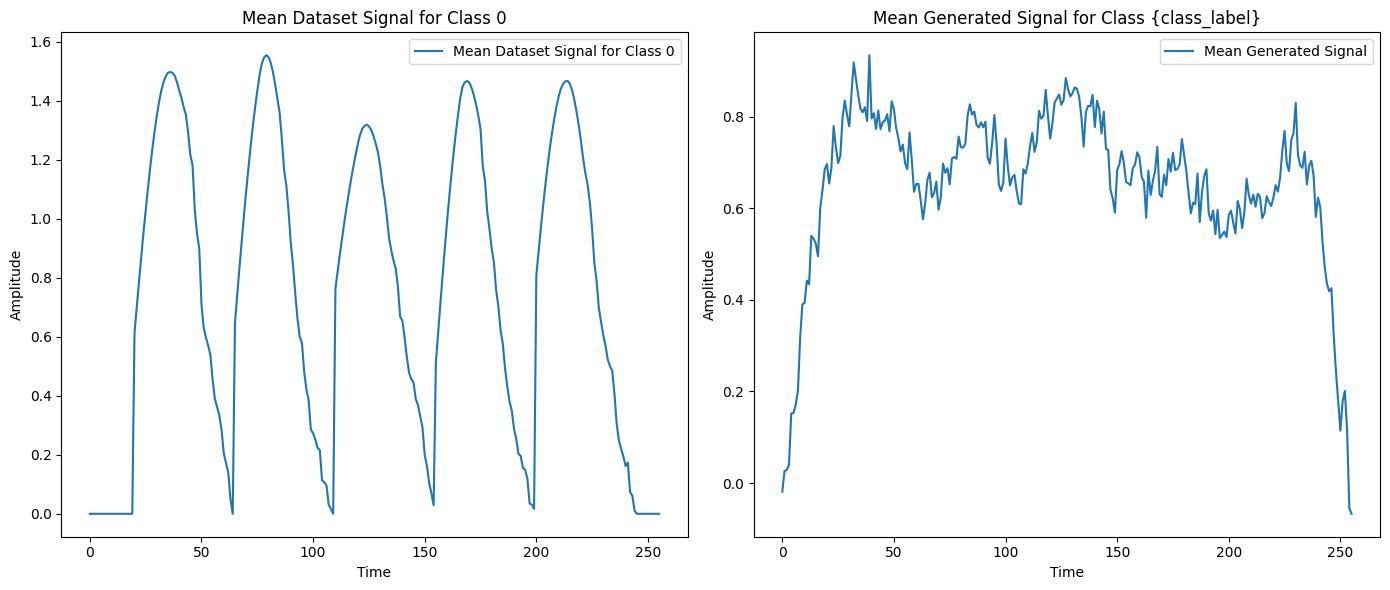

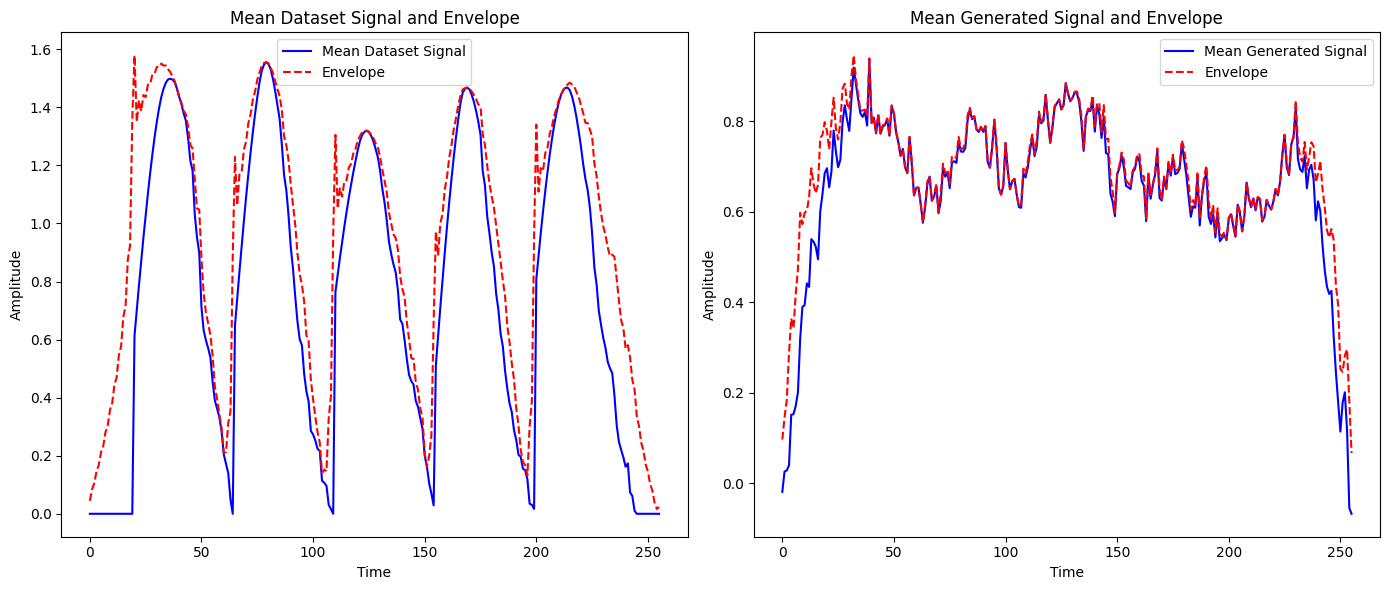

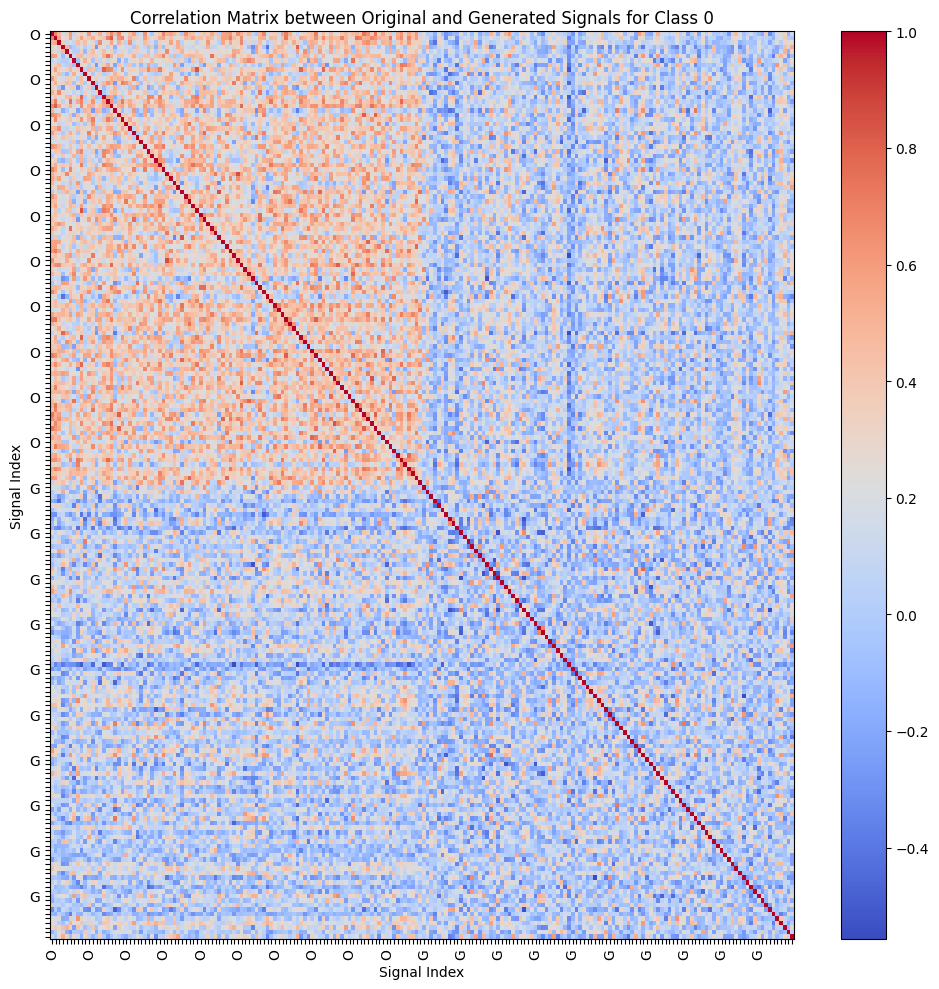

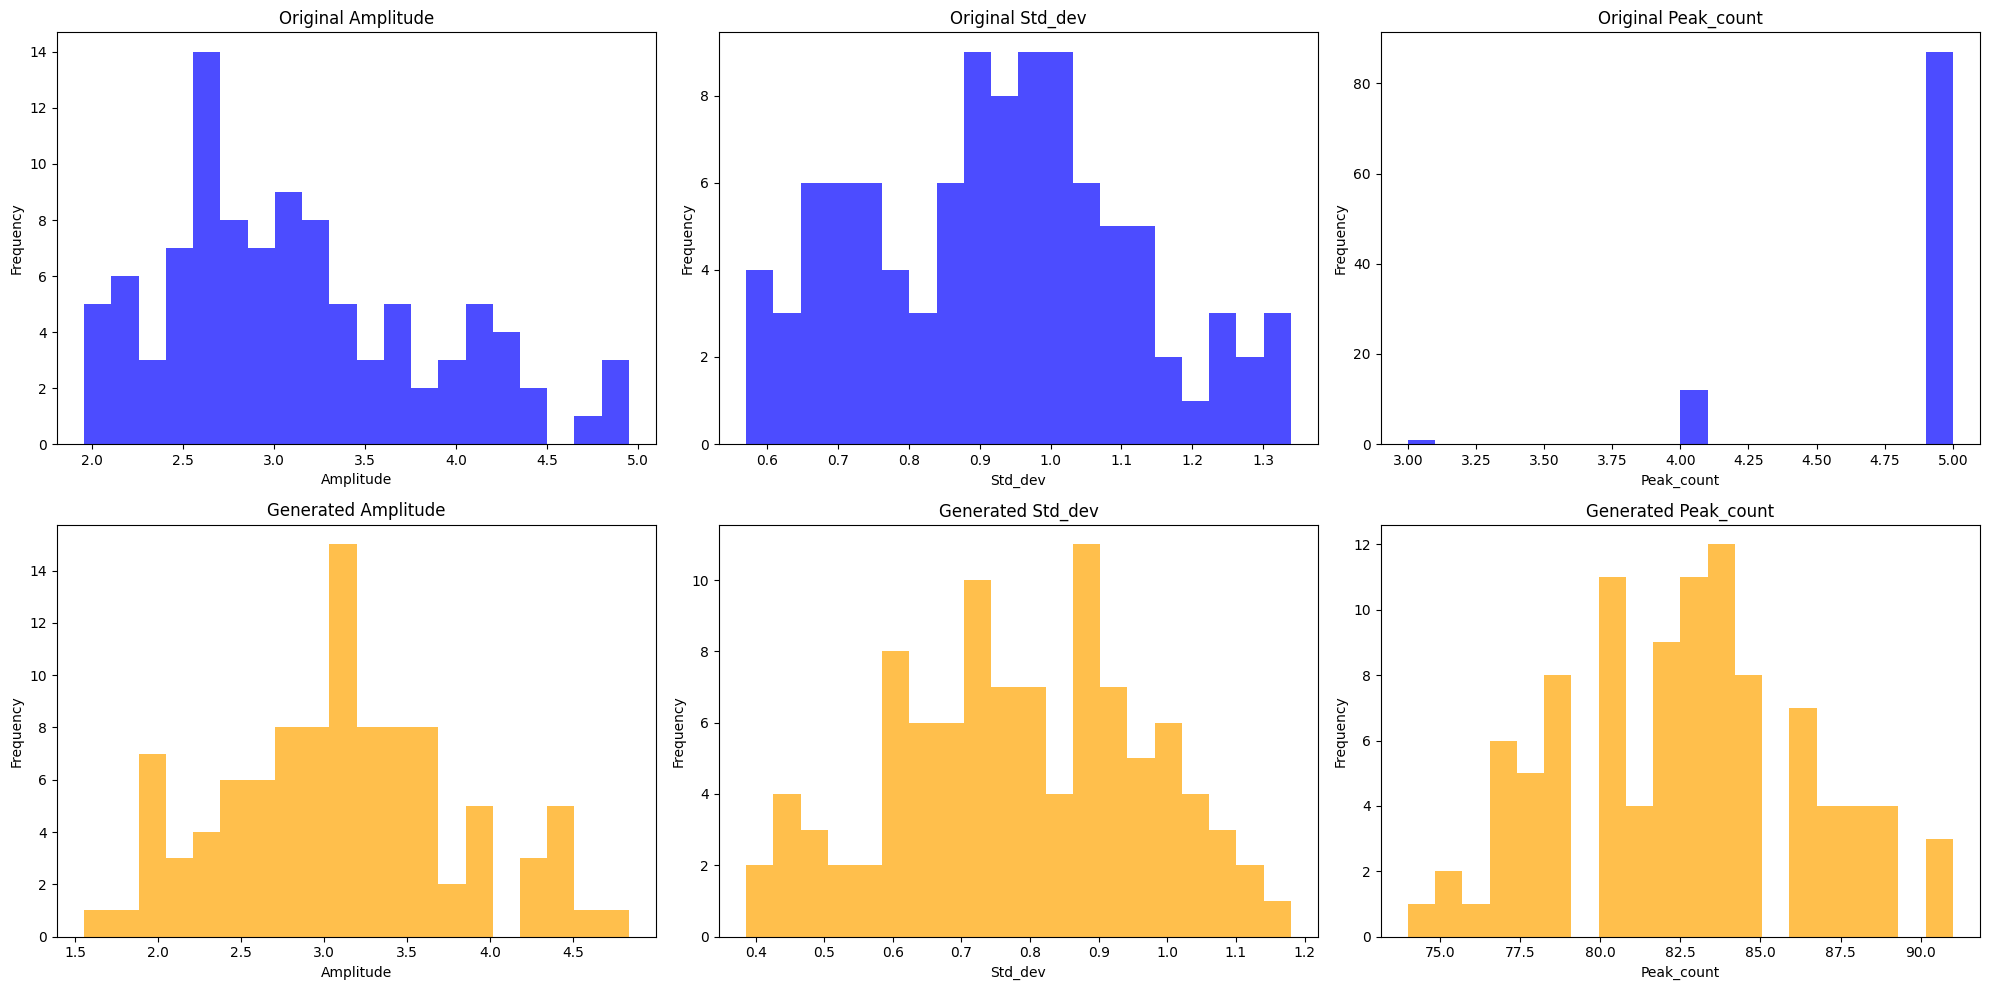

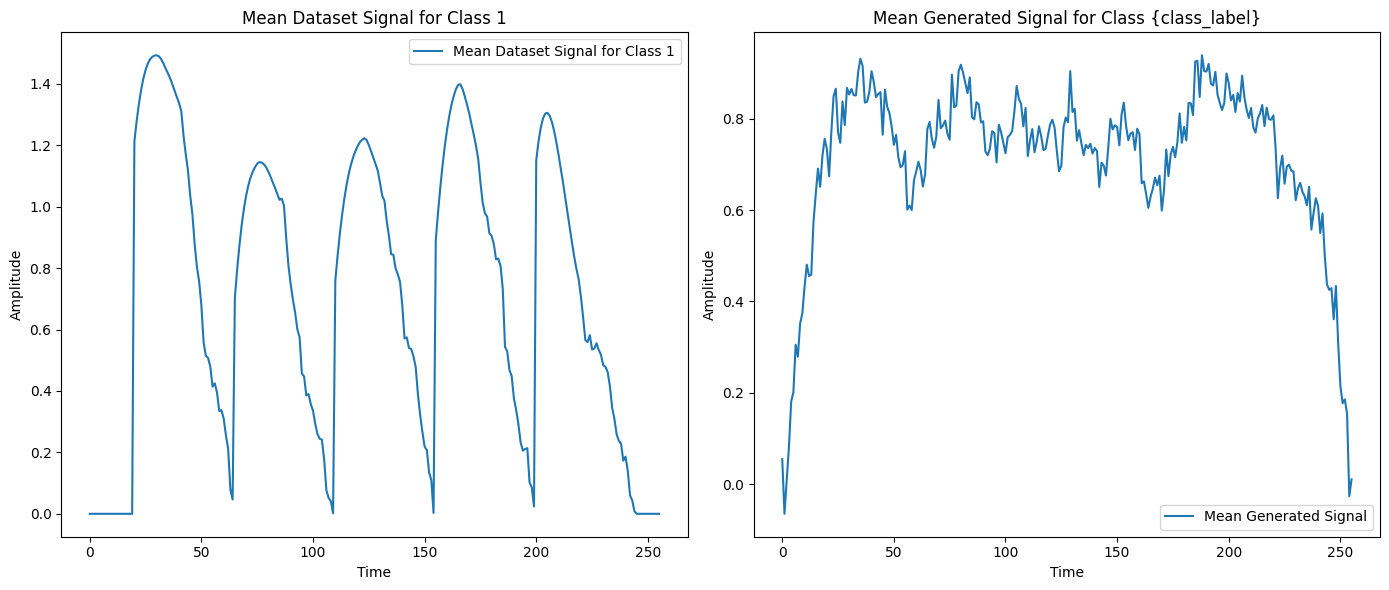

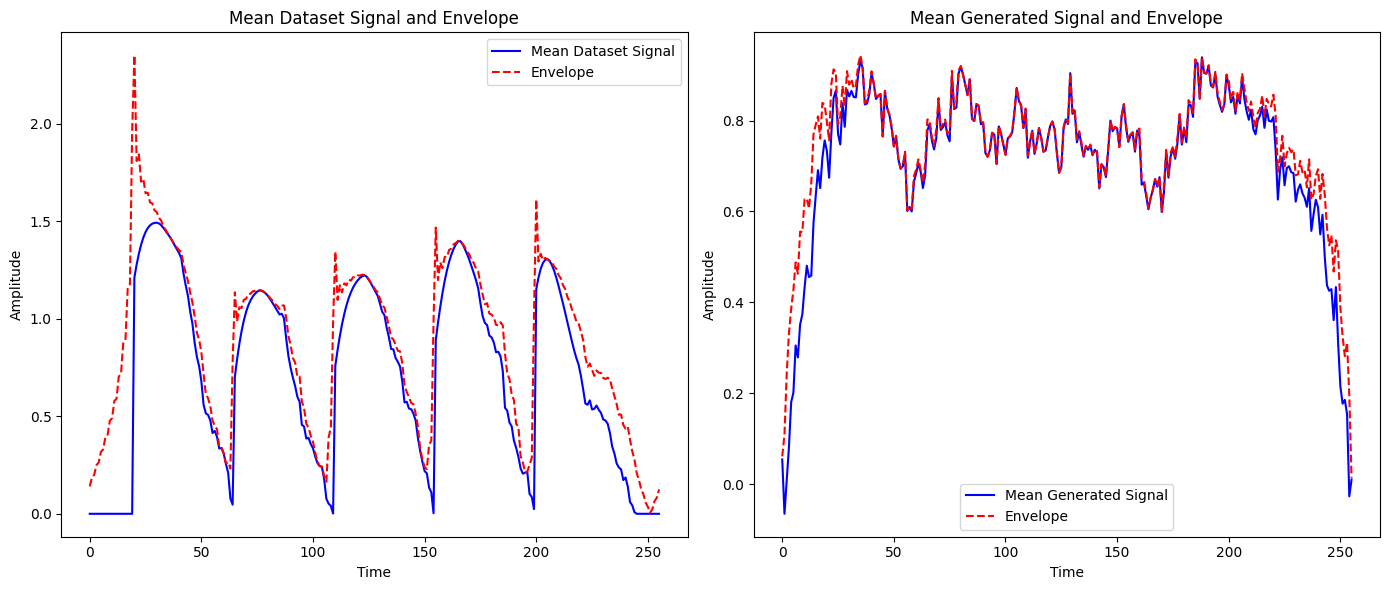

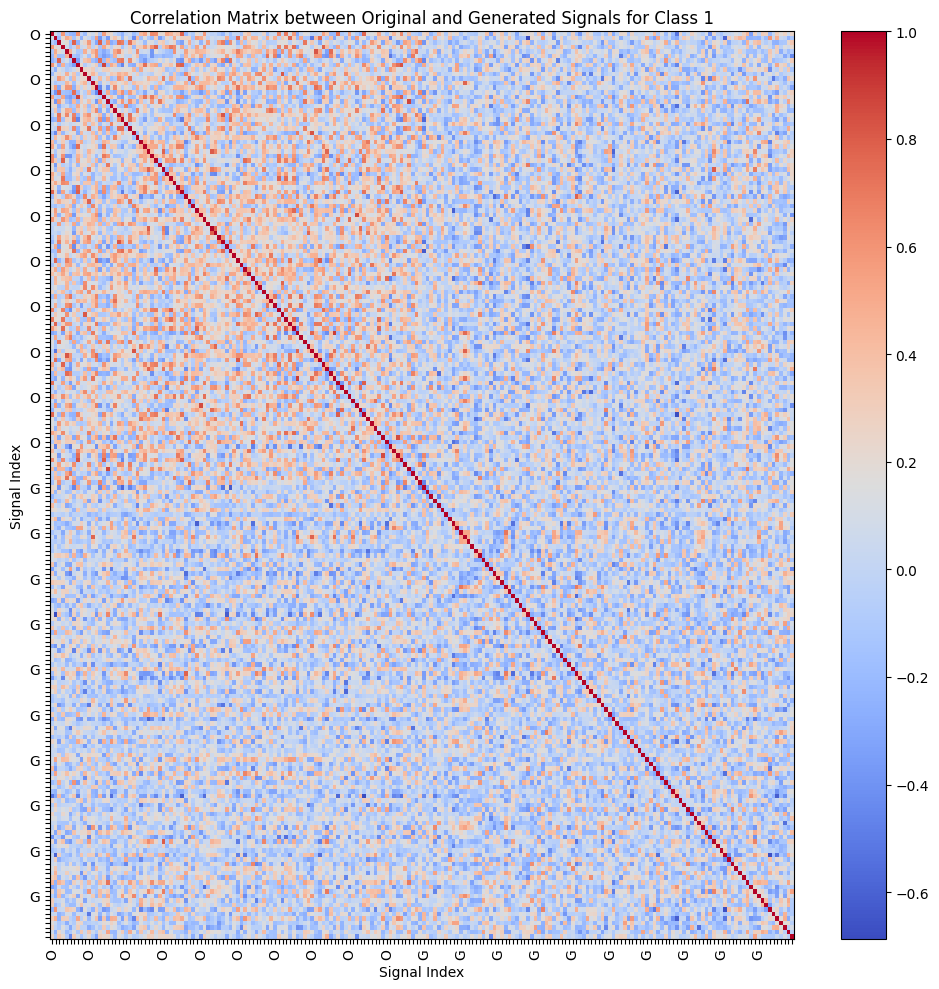

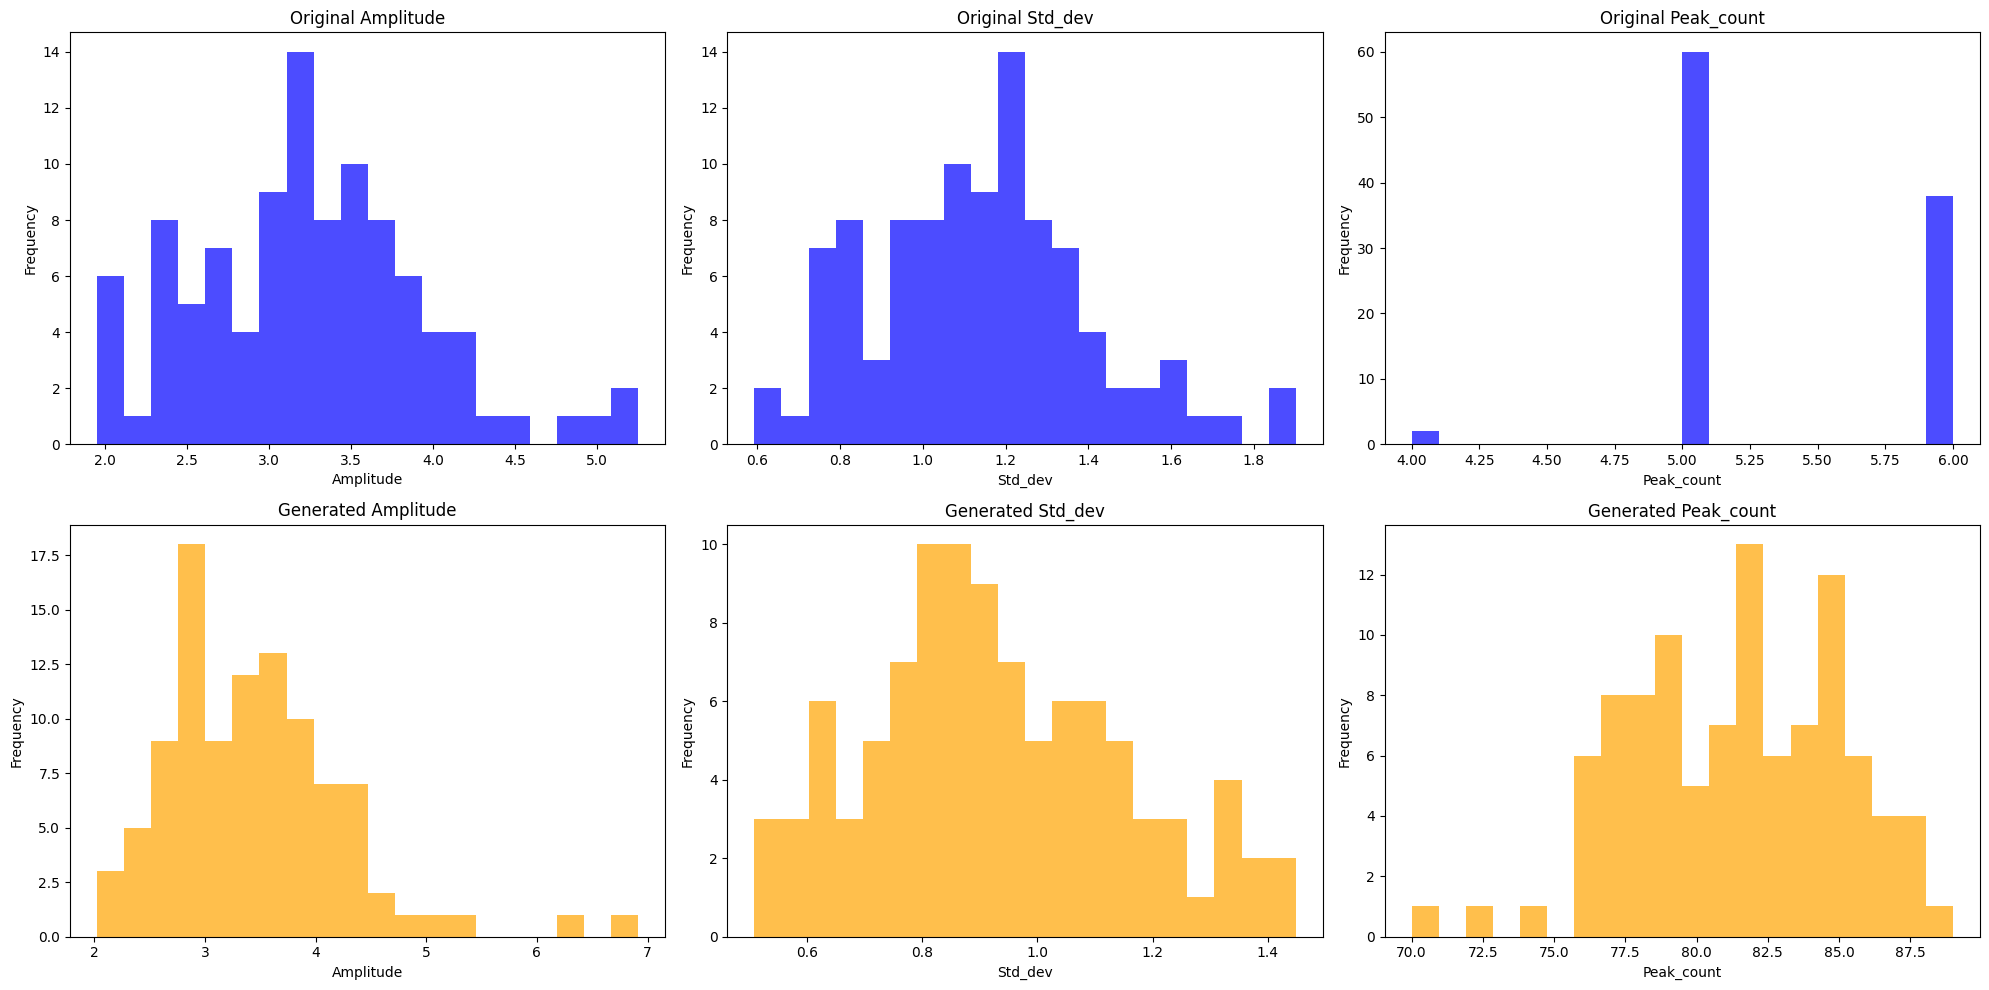

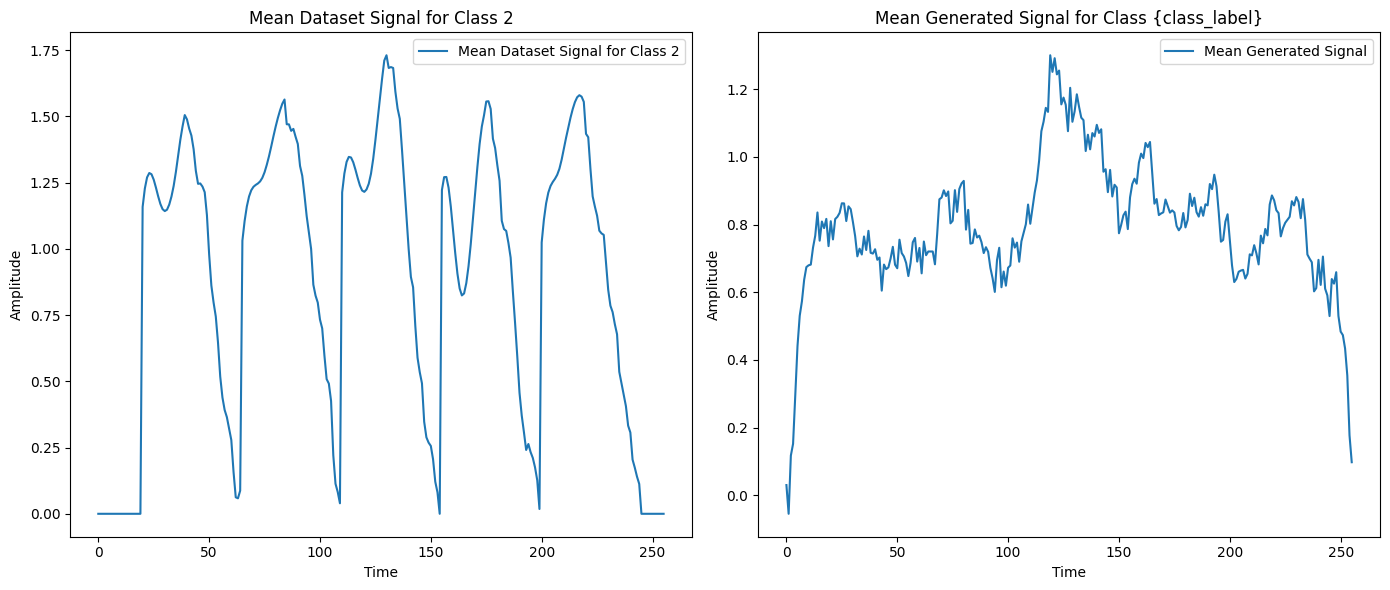

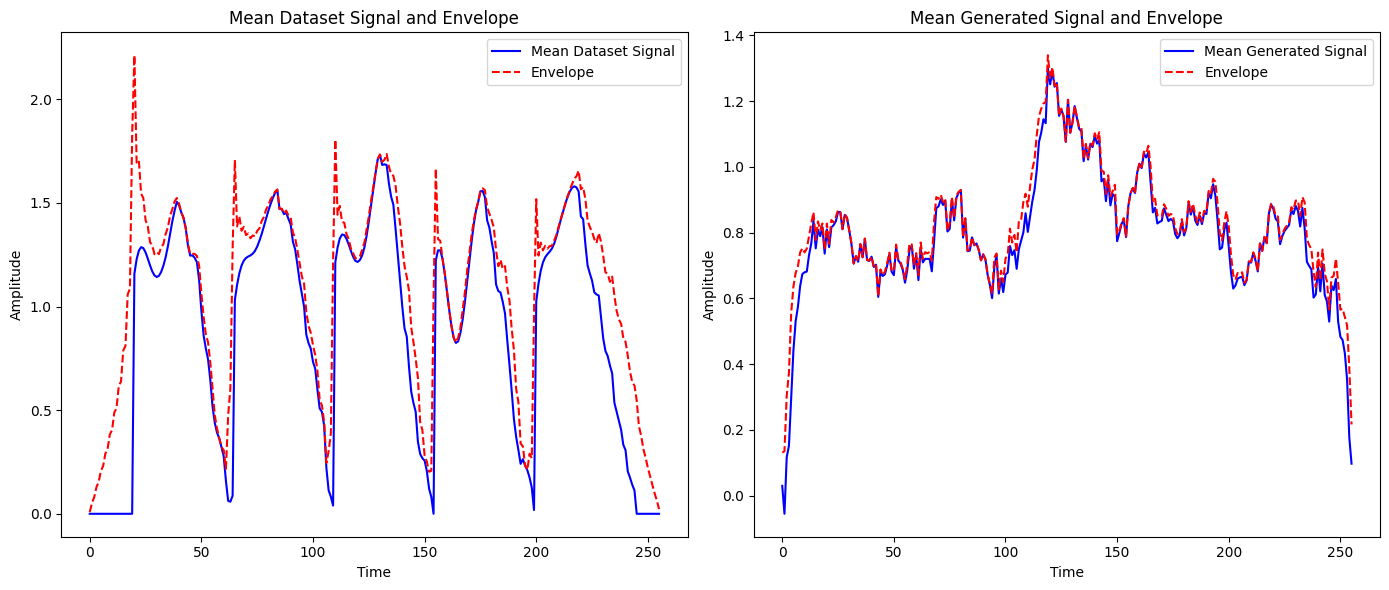

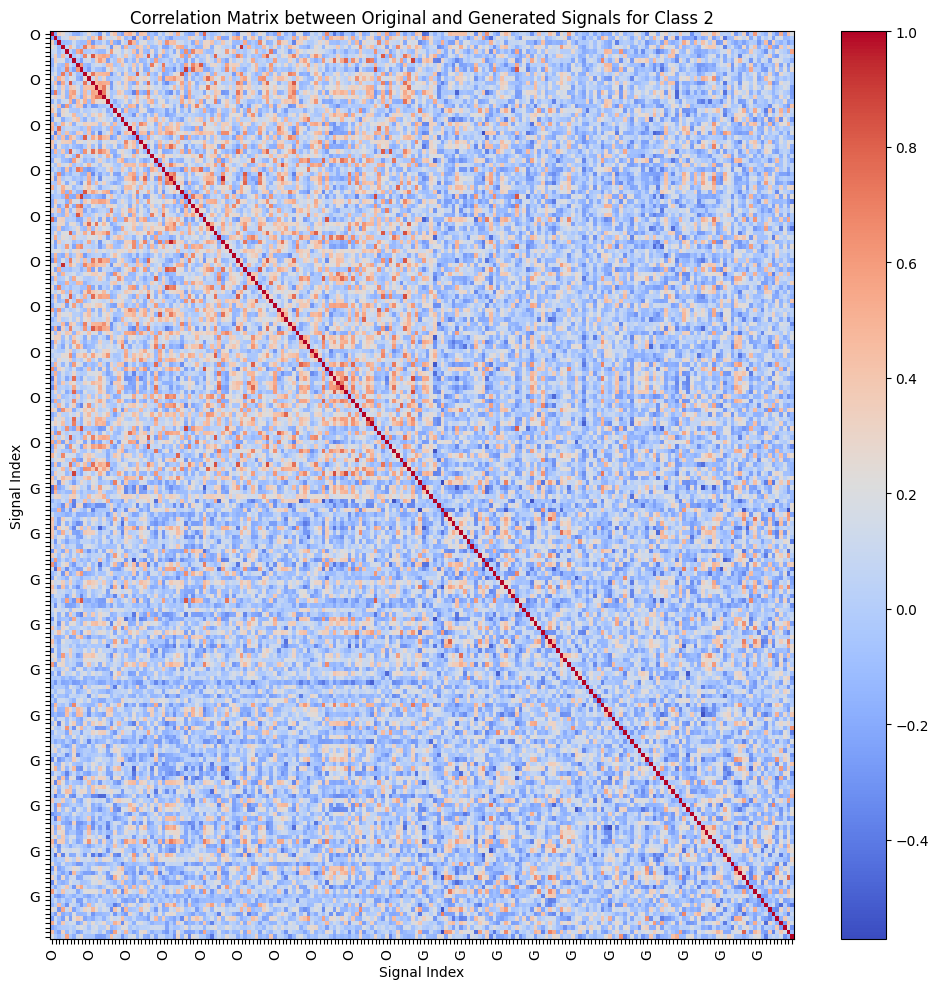

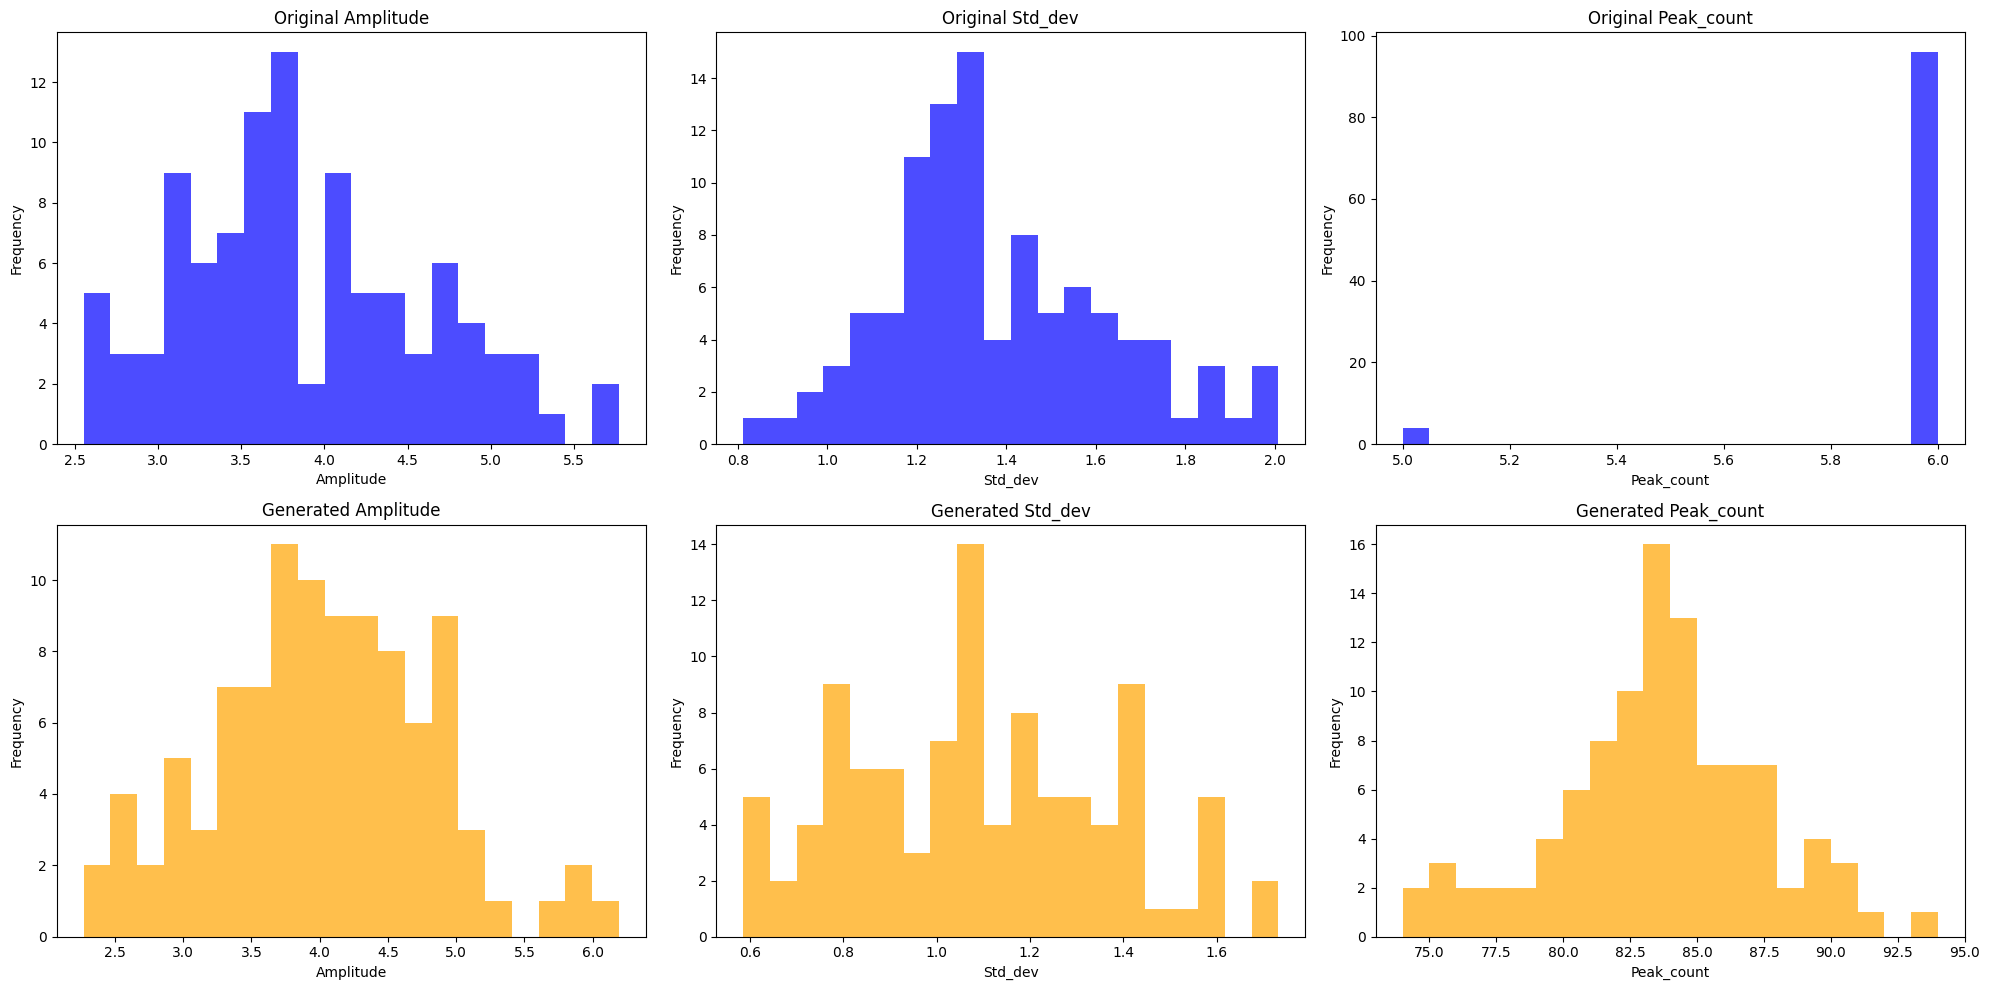

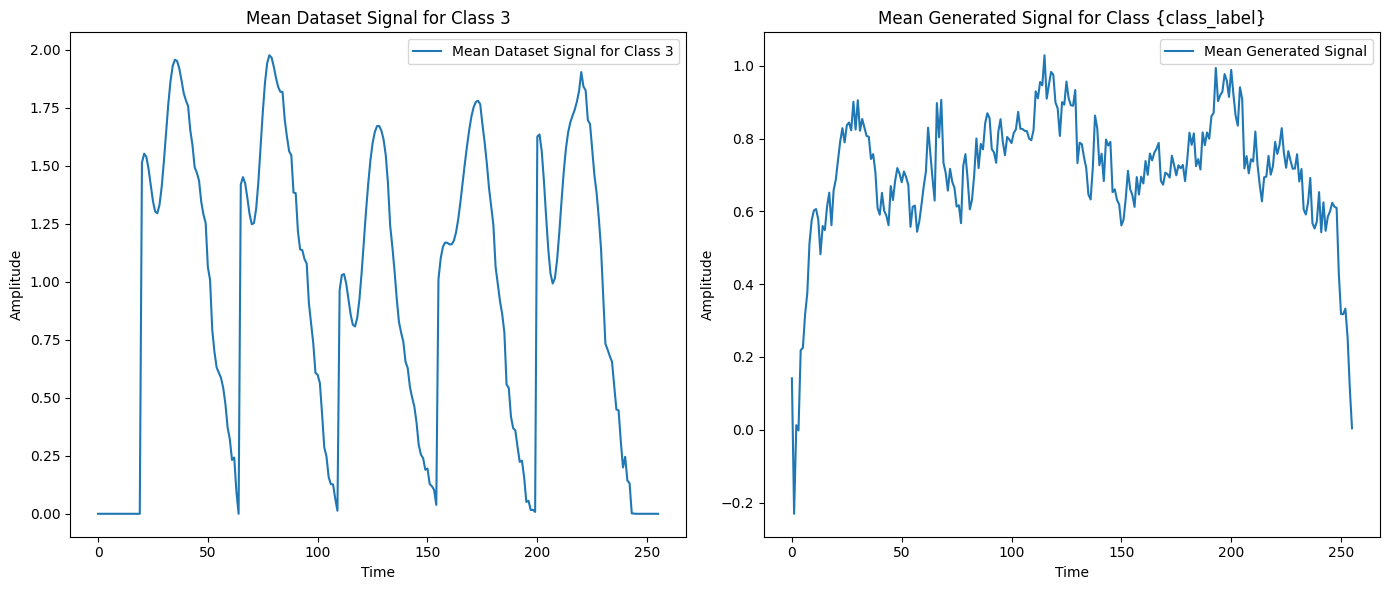

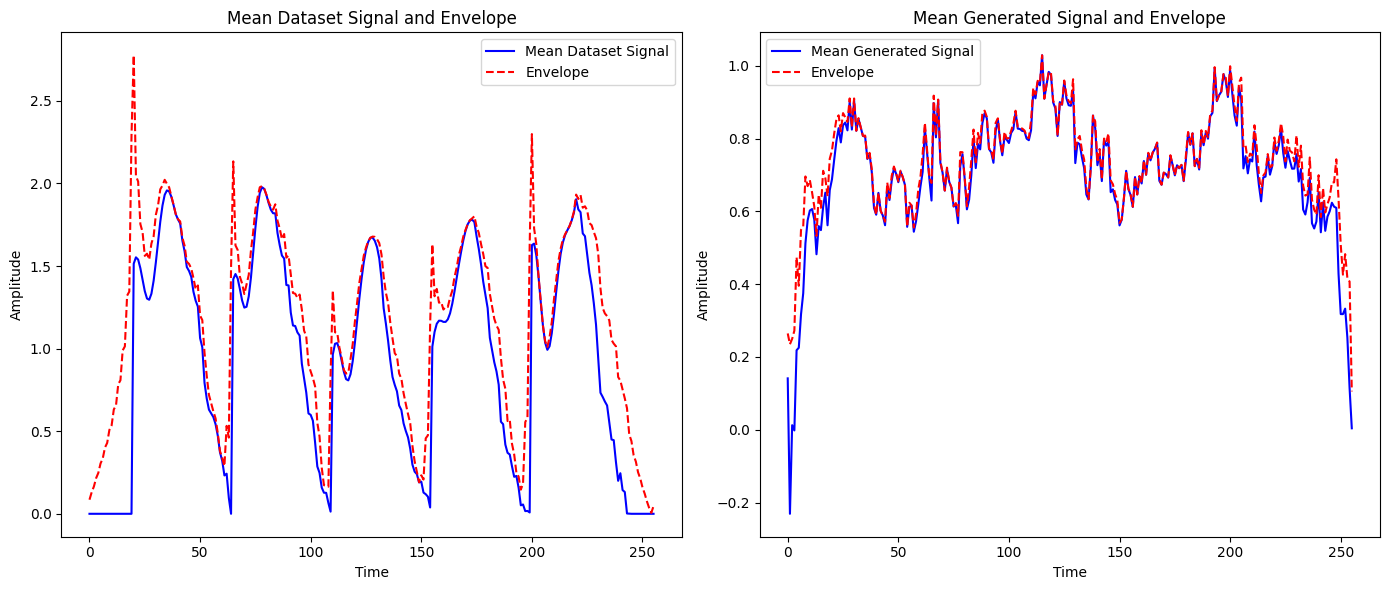

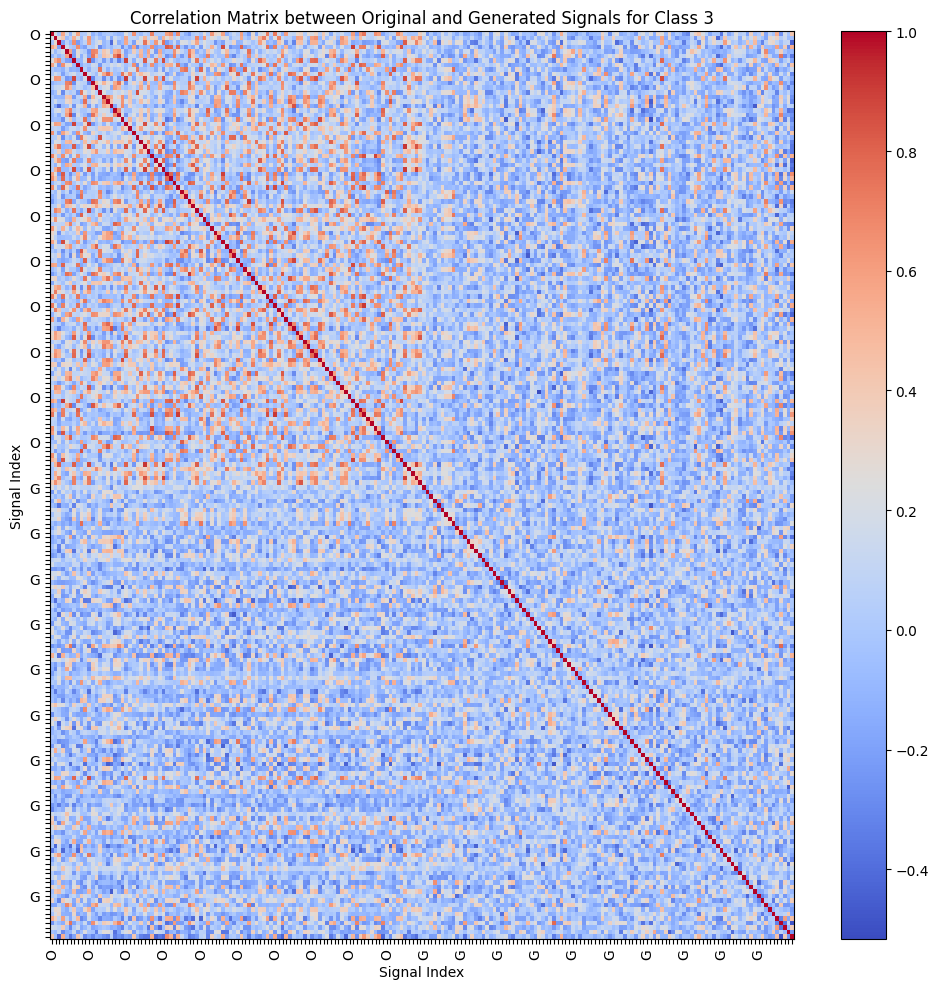

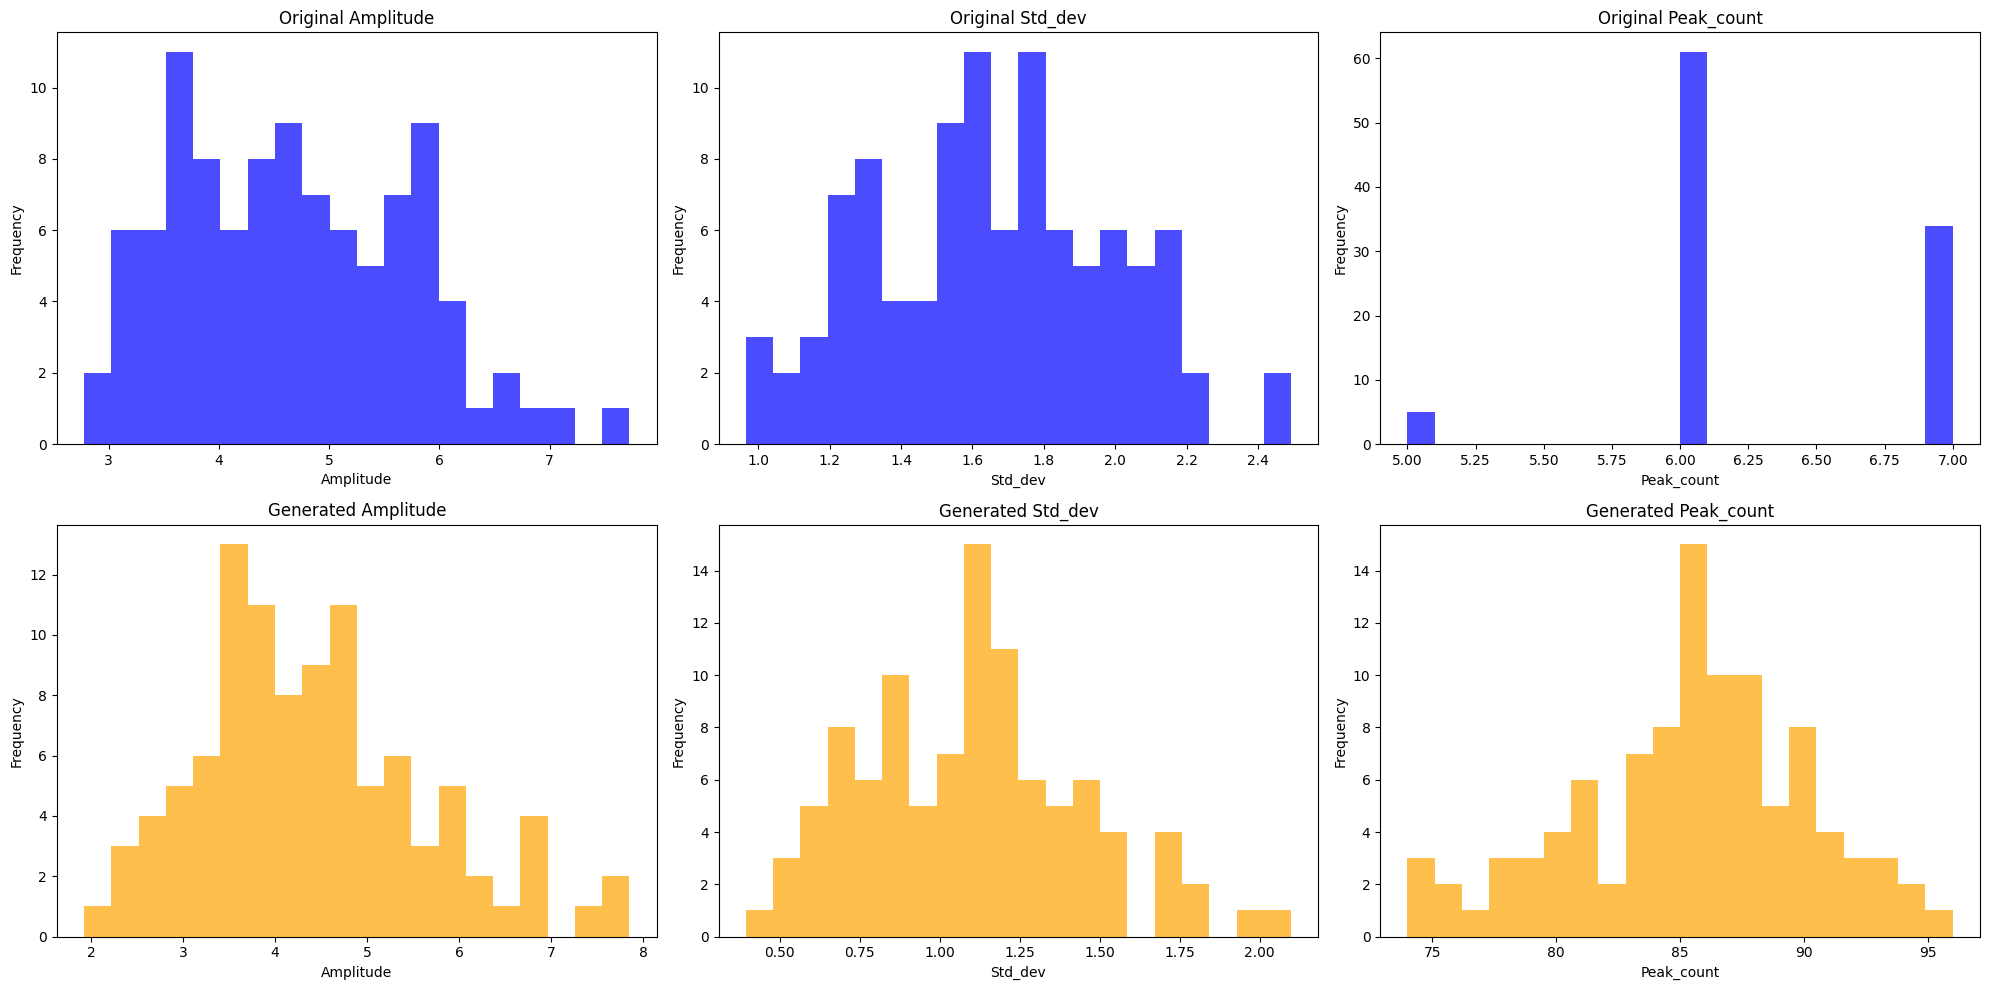

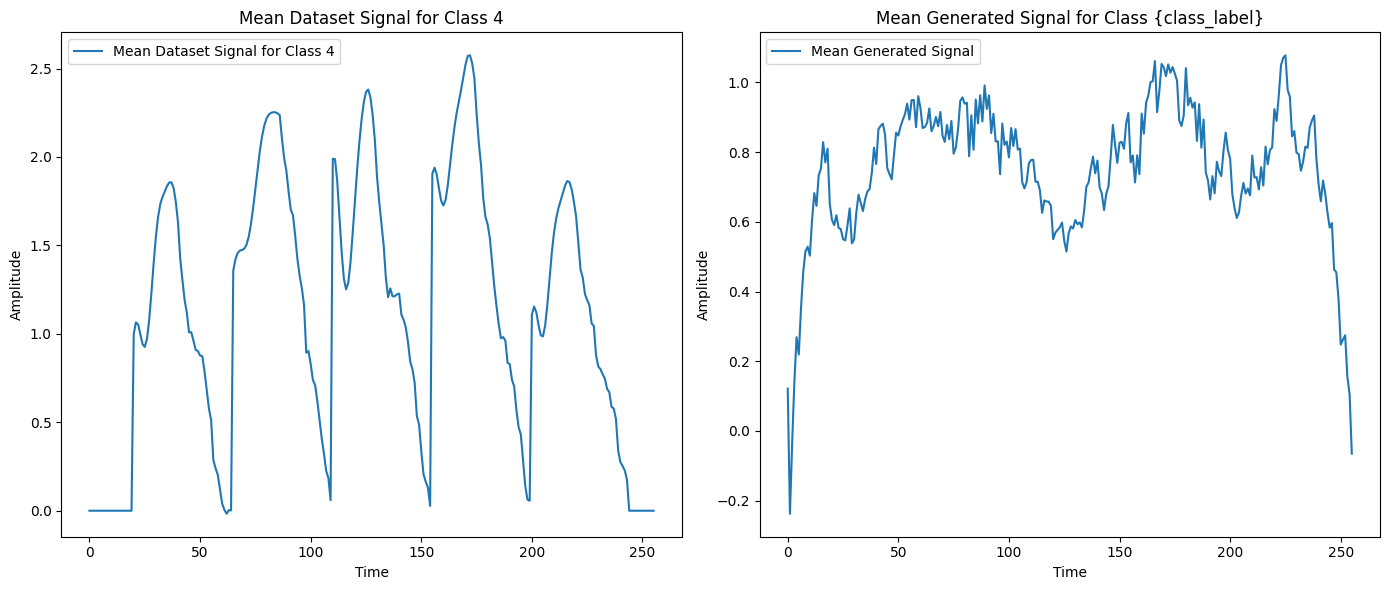

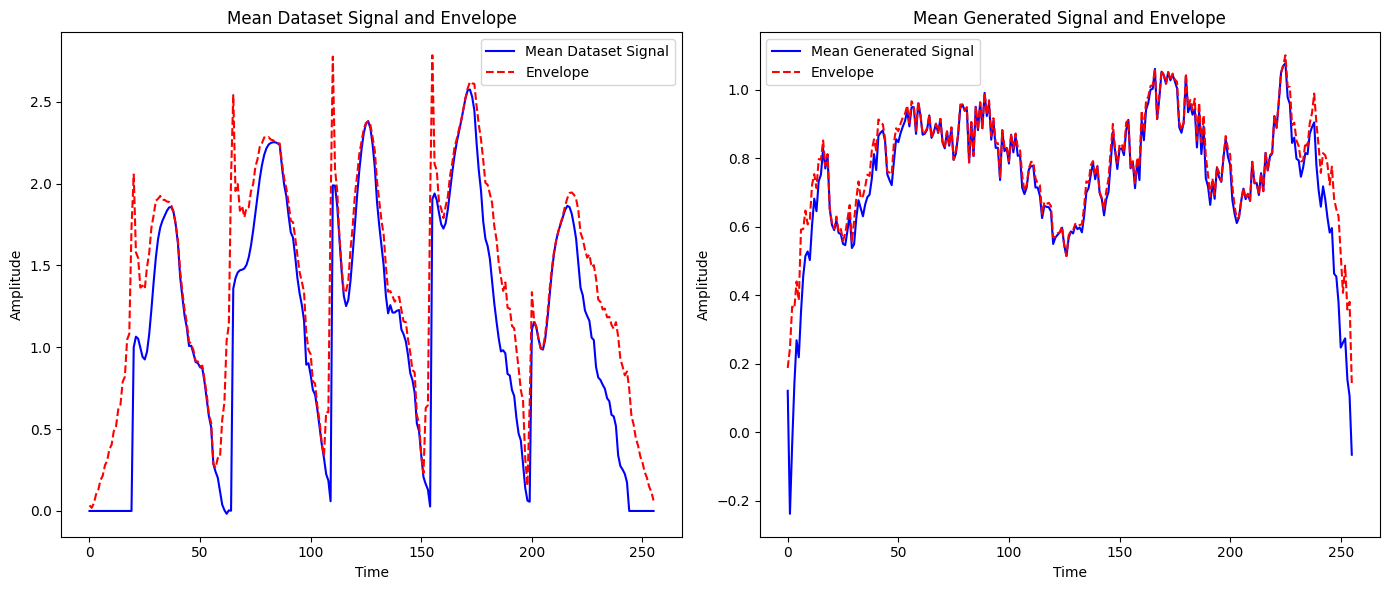

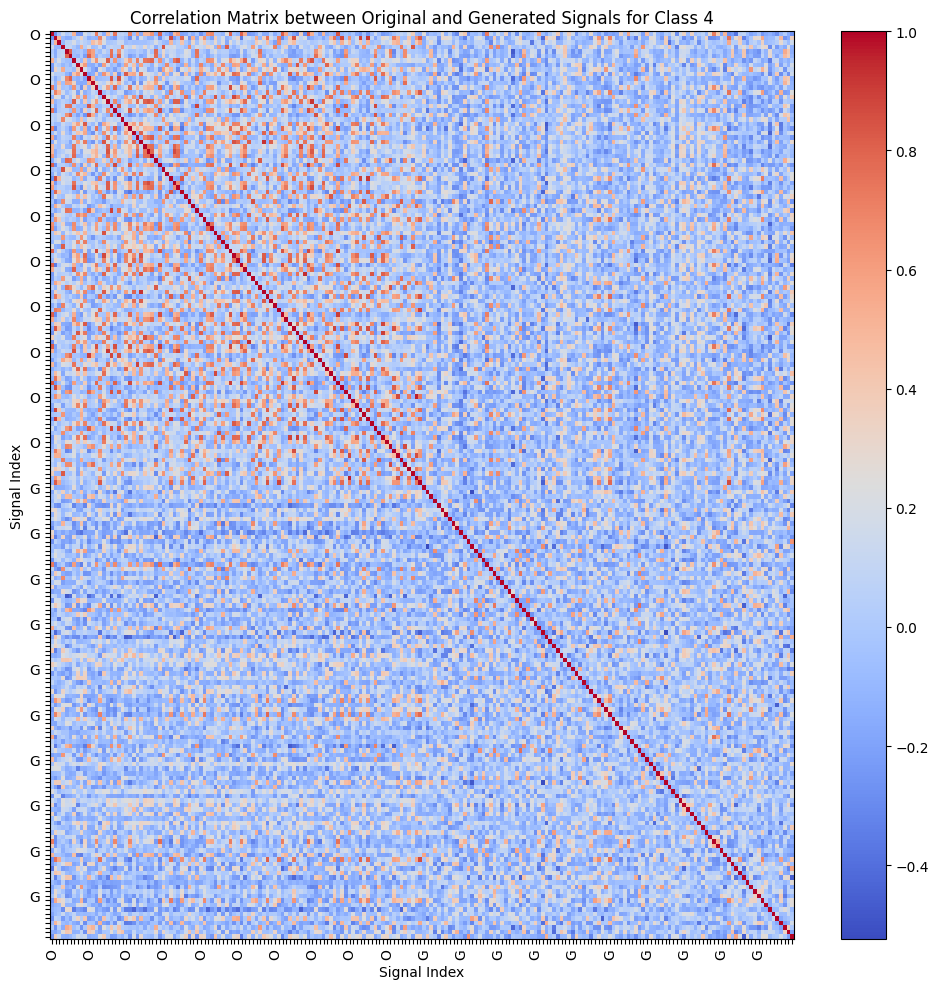

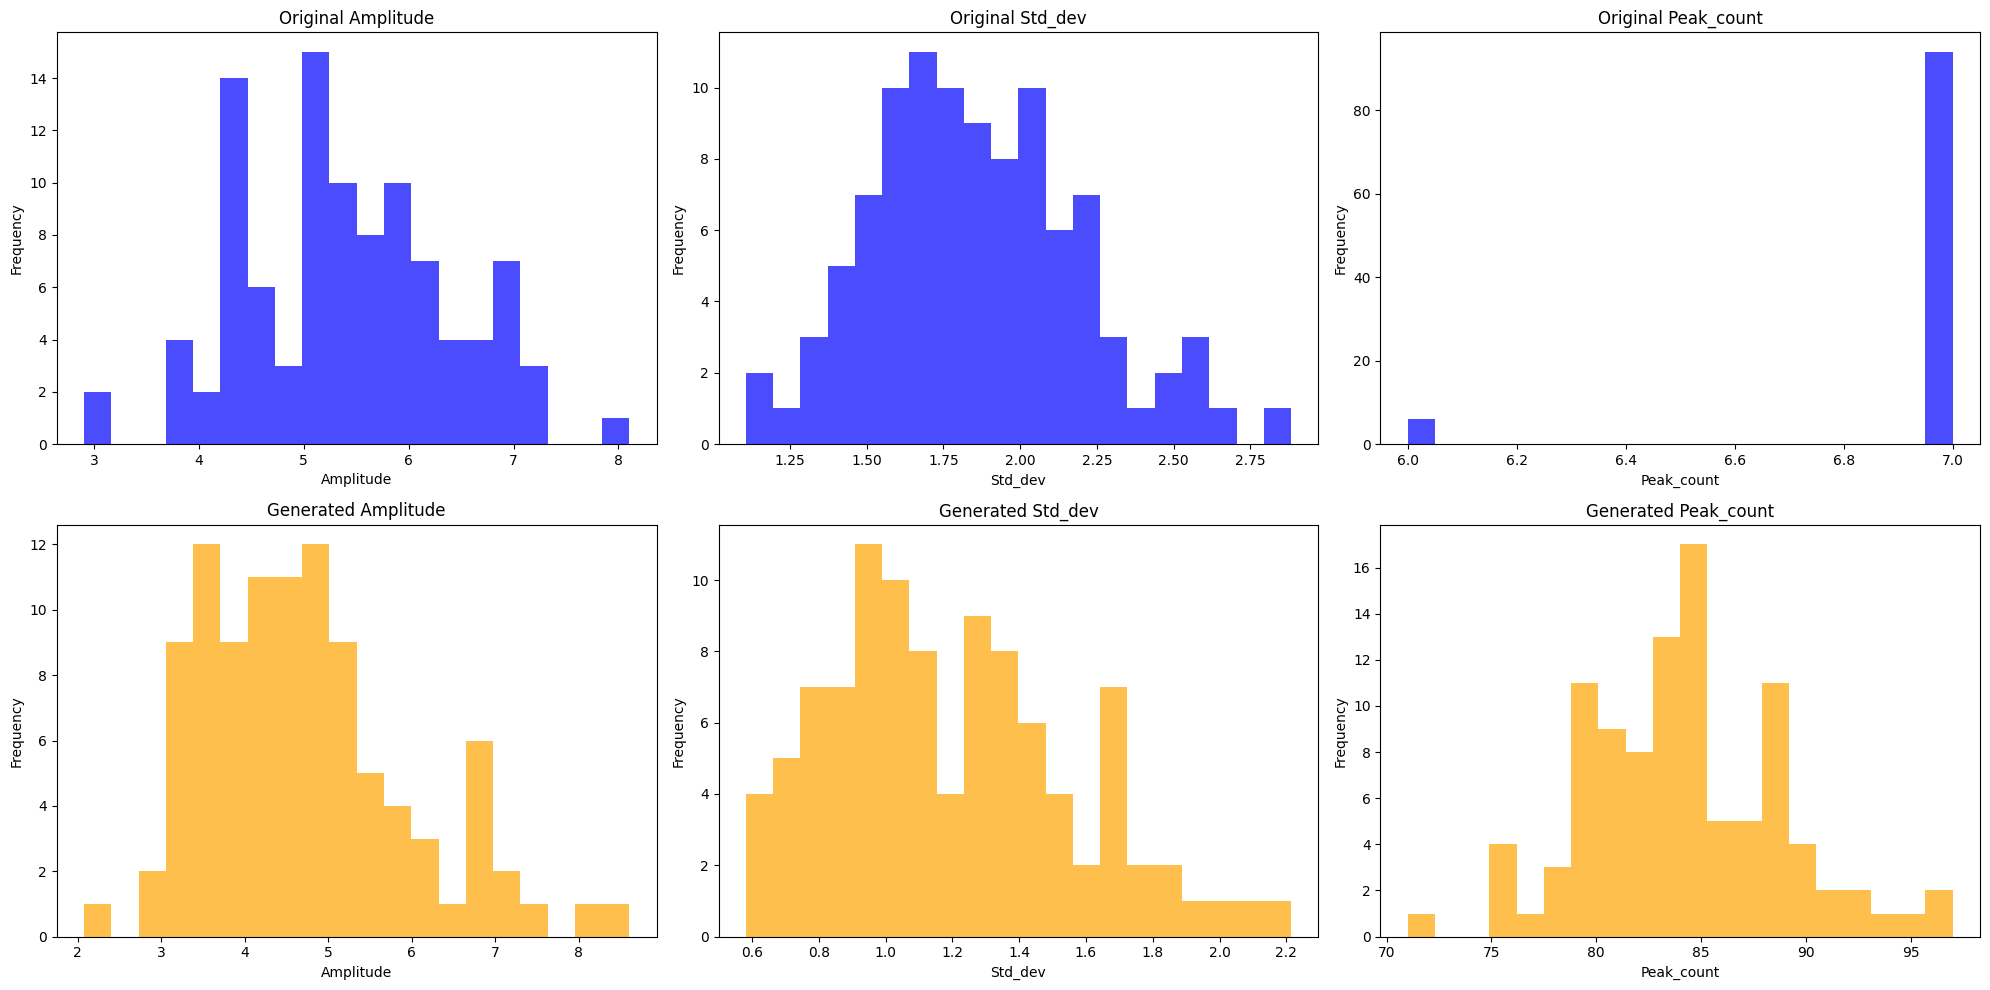

In [12]:
num_signals = 100
batch_size = 10 
project_folder_path = 'C:/Users/Alexia'
datasets_folder_path = os.path.join(project_folder_path, 'datasets')
train_set_path = os.path.join(datasets_folder_path, 'train_set_5class.pth')
train_loader = DataLoader(torch.load(train_set_path), batch_size=128, shuffle=True, collate_fn=custom_collate_fn)






for i in range(5):
    generated_signals1 = []
    signals_accum = []
    for batch_no, data_entry in enumerate(train_loader, start=1):
        signals = data_entry['signals'].squeeze(1)  
        class_labels = data_entry['sc']
        for j in range(signals.size(0)):
            if class_labels[j] == i:
                signals_accum.append(signals[j].numpy())
                if len(signals_accum) >= num_signals:
                    break
        if len(signals_accum) >= num_signals:
            break
    
    with torch.no_grad():
        while len(generated_signals1) < num_signals:
            noise_shape = (batch_size, 1, 256)  # Define the noise shape for the batch
            inputs = torch.randn(noise_shape)
            class_labels = torch.full((10,), fill_value=i, dtype=torch.long)
            batch_signals1 = model_class.p_sample_loop(inputs, class_labels)
            # Append the generated signals to the list and reshape them immediately
            generated_signals1.extend(batch_signals1.squeeze().cpu().detach().numpy())

        # Convert list to NumPy array
        generated_signals1 = np.array(generated_signals1)
        if generated_signals1.shape[0] > num_signals:
            generated_signals1 = generated_signals1[:num_signals]  
    
    mean_orig, mean_gen = plot_mean_signal(train_set_path,i, 100, generated_signals1)
    plot_signals_with_envelope(mean_orig, mean_gen)
    m = correlation_matrix(signals_accum, i, num_signals, generated_signals1)
    original_properties = calculate_properties(signals_accum)
    generated_properties = calculate_properties(generated_signals1)

    plot_histograms(original_properties, generated_properties)